### Setup: Importing Libraries and Dependencies
We begin by importing all necessary libraries for our retrieval and question-answering pipeline. These include libraries for:

- File handling (`os`, `requests`)
- PDF processing (`fitz`)
- Natural language processing (`spacy`, `transformers`, `sentence-transformers`)
- Data processing and visualization (`pandas`, `matplotlib`)
- Deep learning frameworks (`torch`), etc.

In [46]:
import os
import requests
import random
import re

import fitz
import textwrap
from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt
from spacy.lang.en import English

import torch
import numpy as np
from sentence_transformers import util, SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForMaskedLM
from transformers.utils import is_flash_attn_2_available 
from transformers import BitsAndBytesConfig

### Loading the PDF
Here we load the PDF file for processing. The `book.pdf` is loaded, and we'll extract and preprocess its content for later use.

In [2]:
pdf = "book.pdf"

In [3]:
def text_formatter(text :str) -> str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    for pg_no, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({
            "page_no": pg_no+1,
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sen_count_raw": len(text.split(". ")),
            "page_token_count": len(text) / 4, # 1 token = ~4 characters
            "text": text
        })

    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf)
pages_and_texts[:2]

548it [00:09, 55.92it/s] 


[{'page_no': 1,
  'page_char_count': 92,
  'page_word_count': 14,
  'page_sen_count_raw': 3,
  'page_token_count': 23.0,
  'text': 'Reinforcement  Learning An Introduction second edition Richard S. Sutton and Andrew G. Barto'},
 {'page_no': 2,
  'page_char_count': 322,
  'page_word_count': 50,
  'page_sen_count_raw': 2,
  'page_token_count': 80.5,
  'text': 'Adaptive Computation and Machine Learning Francis Bach A complete list of books published in the Adaptive Computation and Machine Learning series appears at the back of this book. The cover design is based on the trajectories of a simulated bicycle controlled by a reinforcement learning system developed by Jette Randløv.'}]

In [4]:
random.sample(pages_and_texts, k=3)

[{'page_no': 493,
  'page_char_count': 3711,
  'page_word_count': 567,
  'page_sen_count_raw': 22,
  'page_token_count': 927.75,
  'text': '17.4. Designing Reward Signals 471 in which the reward signal is linear. The method also requires completely solving the problem (e.g., by dynamic programming methods) multiple times. These diﬃculties notwithstanding, Abbeel and Ng (2004) argue that the inverse reinforcement learning approach can sometimes be more e↵ective than supervised learning for beneﬁting from the behavior of an expert. Another approach to ﬁnding a good reward signal is to automate the trial-and-error search for a good signal that we mentioned above. From an application perspective, the reward signal is a parameter of the learning algorithm. As is true for other algorithm parameters, the search for a good reward signal can be automated by deﬁning a space of feasible candidates and applying an optimization algorithm. The optimization algorithm evaluates each candidate reward s

In [5]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_no,page_char_count,page_word_count,page_sen_count_raw,page_token_count,text
0,1,92,14,3,23.00,Reinforcement Learning An Introduction second...
1,2,322,50,2,80.50,Adaptive Computation and Machine Learning Fran...
2,3,147,20,3,36.75,Reinforcement Learning: An Introduction second...
3,4,562,89,9,140.50,c⃝2018 Richard S. Sutton and Andrew G. Barto T...
4,5,27,6,2,6.75,In memory of A. Harry Klopf


In [6]:
df.describe().round(2)

,page_no,page_char_count,page_word_count,page_sen_count_raw,page_token_count
count,548.00,548.00,548.00,548.00,548.00
mean,274.50,2831.53,468.33,34.06,707.88
std,158.34,978.03,171.62,78.98,244.51
min,1.00,0.00,1.00,1.00,0.00
25%,137.75,2333.75,396.75,16.00,583.44
50%,274.50,2990.00,476.50,20.00,747.50
75%,411.25,3440.50,548.00,24.00,860.12
max,548.00,13578.00,2665.00,884.00,3394.50


Token count is important to think about because:
1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example: An embedding model may have been trained to embed seq of 384 tokens into numerical space.

As for LLMs, they can't accept the infinite tokens in their context window.

To prepare the text for embedding and retrieval, we first split the extracted text into individual sentences. Using the `spaCy` library, each sentence is tokenized, which is an essential preprocessing step in Natural Language Processing (NLP) workflows.

- **Tokenization**: The process of breaking down text into smaller units (tokens), such as words or phrases.
- **Sentence Splitting**: Separating text into individual sentences, which is helpful for understanding context at a finer level.


### Text Processing (splitting pages into sentences)

In [7]:
nlp = English()
nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    item["page_sen_count_spacy"] = len(item["sentences"])

100%|██████████| 548/548 [00:01<00:00, 510.49it/s]


In [8]:
random.sample(pages_and_texts, k=1)

[{'page_no': 227,
  'page_char_count': 2550,
  'page_word_count': 457,
  'page_sen_count_raw': 21,
  'page_token_count': 637.5,
  'text': '9.4. Linear Methods 205 the inner product between w and x(s): ˆv(s,w) .= w>x(s) .= d X i=1 wixi(s). (9.8) In this case the approximate value function is said to be linear in the weights, or simply linear. The vector x(s) is called a feature vector representing state s. Each component xi(s) of x(s) is the value of a function xi : S ! R. We think of a feature as the entirety of one of these functions, and we call its value for a state s a feature of s. For linear methods, features are basis functions because they form a linear basis for the set of approximate functions. Constructing d-dimensional feature vectors to represent states is the same as selecting a set of d basis functions. Features may be deﬁned in many di↵erent ways; we cover a few possibilities in the next sections. It is natural to use SGD updates with linear function approximation. The 

In [9]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_no,page_char_count,page_word_count,page_sen_count_raw,page_token_count,page_sen_count_spacy
count,548.00,548.00,548.00,548.00,548.00,548.00
mean,274.50,2831.53,468.33,34.06,707.88,23.31
std,158.34,978.03,171.62,78.98,244.51,16.66
min,1.00,0.00,1.00,1.00,0.00,0.00
25%,137.75,2333.75,396.75,16.00,583.44,16.00
50%,274.50,2990.00,476.50,20.00,747.50,21.00
75%,411.25,3440.50,548.00,24.00,860.12,24.00
max,548.00,13578.00,2665.00,884.00,3394.50,106.00


#### Chunking the sentences together

The concept of splitting larger pieces of text into smaller ones.

There is no perfect way to do this.

I'll split into 10 sentences per group (we can experiment here by trying splitting it into 8, 5, etc.)

We can use frameworks to do this like - langchain, but I'll be doing it in raw Python only.

In [10]:
num_sen_chunk_size = 10

def split_list(input_list: list[str],slice_size) -> list[list[str]]:

    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(1, 25))
split_list(test_list, num_sen_chunk_size)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [21, 22, 23, 24]]

In [11]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"], slice_size=num_sen_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 548/548 [00:00<00:00, 320837.32it/s]


In [12]:
random.sample(pages_and_texts, k=1)

[{'page_no': 351,
  'page_char_count': 2505,
  'page_word_count': 428,
  'page_sen_count_raw': 17,
  'page_token_count': 626.25,
  'text': '13.4. REINFORCE with Baseline 329 As a stochastic gradient method, REINFORCE has good theoretical convergence properties. By construction, the expected update over an episode is in the same direction as the performance gradient. This assures an improvement in expected performance for suﬃciently small ↵, and convergence to a local optimum under standard stochastic approx- imation conditions for decreasing ↵. However, as a Monte Carlo method REINFORCE may be of high variance and thus produce slow learning. Exercise 13.3 In Section 13.1 we considered policy parameterizations using the soft-max in action preferences (13.2) with linear action preferences (13.3). For this parameterization, prove that the eligibility vector is r ln ⇡(a|s, ✓) = x(s, a) − X b ⇡(b|s, ✓)x(s, b), (13.9) using the deﬁnitions and elementary calculus. ⇤ 13.4 REINFORCE with Baseli

In [13]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_no,page_char_count,page_word_count,page_sen_count_raw,page_token_count,page_sen_count_spacy,num_chunks
count,548.00,548.00,548.00,548.00,548.00,548.00,548.00
mean,274.50,2831.53,468.33,34.06,707.88,23.31,2.79
std,158.34,978.03,171.62,78.98,244.51,16.66,1.70
min,1.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,137.75,2333.75,396.75,16.00,583.44,16.00,2.00
50%,274.50,2990.00,476.50,20.00,747.50,21.00,3.00
75%,411.25,3440.50,548.00,24.00,860.12,24.00,3.00
max,548.00,13578.00,2665.00,884.00,3394.50,106.00,11.00


In [14]:
pages_and_chunks = []

for item in tqdm(pages_and_texts):
    for sen_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_no"] = item["page_no"]

        joined_sen_chunk = "".join(sen_chunk).replace("  ", " ").strip()
        joined_sen_chunk = re.sub(r"\.([A-Z])", r". \1", joined_sen_chunk)
        
        chunk_dict["sen_chunk"] = joined_sen_chunk

        chunk_dict["chunk_char_count"] = len(joined_sen_chunk)
        chunk_dict["chunk_word_count"] = len([w for w in joined_sen_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sen_chunk)/4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

100%|██████████| 548/548 [00:00<00:00, 14412.78it/s]


1528

In [15]:
random.sample(pages_and_chunks, k=1)

[{'page_no': 104,
  'sen_chunk': '82 Chapter 4: Dynamic Programming Policy iteration often converges in surprisingly few iterations, as the example of Jack’s car rental illustrates, and as is also illustrated by the example in Figure 4.1. The bottom- left diagram of Figure 4.1 shows the value function for the equiprobable random policy, and the bottom-right diagram shows a greedy policy for this value function. The policy improvement theorem assures us that these policies are better than the original random policy. In this case, however, these policies are not just better, but optimal, proceeding to the terminal states in the minimum number of steps. In this example, policy iteration would ﬁnd the optimal policy after just one iteration. Exercise 4.4 The policy iteration algorithm on page 80 has a subtle bug in that it may never terminate if the policy continually switches between two or more policies that are equally good. This is ok for pedagogy, but not for actual use. Modify the ps

In [16]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_no,chunk_char_count,chunk_word_count,chunk_token_count
count,1528.00,1528.00,1528.00,1528.00
mean,310.77,1013.66,166.77,253.42
std,169.81,551.08,94.48,137.77
min,1.00,1.00,1.00,0.25
25%,158.75,479.75,68.00,119.94
50%,319.00,1088.50,183.00,272.12
75%,477.00,1445.50,241.00,361.38
max,548.00,2894.00,523.00,723.50


In [17]:
## If you want to remove some outliers, in my case - I have some of useful text in those tokens, so I won't perform the below action.

# min_token = 30

# for row in df[df["chunk_token_count"]<= min_token].sample(5).iterrows():
#     print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sen_chunk"]}')

# pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
# pages_and_chunks_over_min_token_len[:2]

### Embedding text chunks

The machines does not understand human natural language.

Embedding is a very important and wide concept.

Embeddings are numerical representations of real-world objects that machine learning (ML) and artificial intelligence (AI) systems use to understand complex knowledge domains like humans do.

Basically, in this we convert the words into numbers.

### Embedding Text with Sentence Transformers
We use the `sentence-transformers` library to convert the tokenized sentences into embeddings. These embeddings are high-dimensional numerical representations of the sentences, which capture semantic meaning. 

- **Embedding Model**: We use a pre-trained transformer-based model to generate embeddings for each sentence. These embeddings are crucial for the next step—similarity search and retrieval.

In [18]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")

/home/ps/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Embedding Model: `all-mpnet-base-v2`
We are using the `all-mpnet-base-v2` embedding model, which offers a good balance between performance and efficiency. Here are the key details:

- **Embedding Dimension**: 768-dimensional vector for each sentence.
- **Token Capacity**: It can process approximately 384 tokens per input, making it suitable for handling moderately long sentences or paragraphs.

While there are larger models available that may provide better accuracy, `all-mpnet-base-v2` is a lightweight and fast model, offering a practical trade-off between speed and accuracy. This makes it a popular choice for real-time applications where inference time is critical.

In [19]:
# Example
sentences = ["In this video we'll build a Retrieval Augmented Generation (RAG) pipeline to run locally from scratch.",
"There are frameworks to do this such as LangChain and LlamaIndex, however, building from scratch means that you'll know all the parts of the puzzle."]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for s, embedding in embeddings_dict.items():
    print("Sentence: ", s, "\nembedding: ", embedding)

Sentence:  In this video we'll build a Retrieval Augmented Generation (RAG) pipeline to run locally from scratch. 
embedding:  [ 1.27117094e-02  5.70679307e-02 -1.22887827e-02 -1.24702239e-02
  1.46538438e-02 -1.11888358e-02  2.23378986e-02 -1.02507891e-02
  7.80888973e-03 -1.86291151e-02 -1.60428993e-02 -6.65122038e-03
 -4.22881544e-02  2.52040345e-02  2.04589777e-02 -3.47740278e-02
  4.25528213e-02  2.73414068e-02 -6.75075054e-02  1.02891186e-02
 -2.62960829e-02  2.62657963e-02 -7.53578846e-04  1.47443051e-02
 -3.05145010e-02 -1.60359999e-03  7.04384223e-03  5.76191917e-02
  1.49853760e-02 -2.01013200e-02  4.20485018e-03  1.68845765e-02
  5.28995730e-02  4.82740253e-02  1.43003786e-06 -3.75059023e-02
 -3.33905518e-02 -8.42809270e-04 -2.93122716e-02 -9.02342889e-03
  5.30875213e-02  1.02601506e-01 -5.74767590e-04  4.64090779e-02
 -4.31459211e-02 -2.90811397e-02  5.26887663e-02 -3.65647022e-03
  4.65935171e-02  6.58741370e-02  6.12483779e-03 -2.78033037e-02
  1.13009324e-03 -3.04739382

In [20]:
embeddings[0].shape

(768,)

In [21]:
%%time

embedding_model.to("cuda")

for item in tqdm(pages_and_chunks):
    item["embedding"] = embedding_model.encode(item["sen_chunk"])

100%|██████████| 1528/1528 [00:39<00:00, 39.00it/s]

CPU times: user 2min 10s, sys: 4.69 s, total: 2min 15s
Wall time: 40 s


In [22]:
text_chunks = [item["sen_chunk"] for item in pages_and_chunks]
text_chunks[410]

'150 Chapter 7: n-step Bootstrapping The o↵-policy version of n-step Expected Sarsa would use the same update as above for n-step Sarsa except that the importance sampling ratio would have one less factor in it. That is, the above equation would use ⇢t+1:t+n−1 instead of ⇢t+1:t+n, and of course it would use the Expected Sarsa version of the n-step return (7.7). This is because in Expected Sarsa all possible actions are taken into account in the last state; the one actually taken has no e↵ect and does not have to be corrected for.7.4 *Per-decision Methods with Control Variates The multi-step o↵-policy methods presented in the previous section are simple and conceptually clear, but are probably not the most eﬃcient. A more sophisticated approach would use per-decision importance sampling ideas such as were introduced in Section 5.9. To understand this approach, ﬁrst note that the ordinary n-step return (7.1), like all returns, can be written recursively. For the n steps ending at horizon

In [23]:
len(text_chunks)

1528

In [24]:
%%time

text_chunk_embedding = embedding_model.encode(
    text_chunks, 
    batch_size=32,
    convert_to_tensor=True
)

text_chunk_embedding

CPU times: user 38.9 s, sys: 674 ms, total: 39.6 s
Wall time: 31.3 s


tensor([[-7.5110e-03, -3.4731e-02, -1.7040e-02,  ...,  9.4942e-02,
          1.6077e-03, -1.7399e-02],
        [-6.0942e-05, -8.1873e-03, -4.3049e-02,  ...,  3.6037e-02,
          2.7225e-02, -4.0893e-02],
        [-1.1954e-02, -3.3365e-02, -9.0336e-03,  ...,  1.1176e-01,
          1.3156e-02, -1.5369e-02],
        ...,
        [-2.7321e-02, -2.9087e-02, -2.1912e-02,  ...,  1.8408e-02,
          5.5075e-03, -2.7235e-02],
        [-7.7170e-03,  6.4527e-03, -5.7771e-02,  ...,  2.7591e-02,
         -1.9960e-02, -1.1424e-02],
        [-1.1219e-02,  4.7273e-02, -2.8951e-02,  ...,  4.3309e-02,
         -5.9762e-02,  3.5855e-03]], device='cuda:0')

### Save embeddings

In [25]:
text_chunks_and_embeddings = pd.DataFrame(pages_and_chunks)
text_chunks_and_embeddings.head()

,page_no,sen_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,Reinforcement Learning An Introduction second ...,91,13,22.75,"[-0.007511104, -0.034730483, -0.017040377, -0...."
1,2,Adaptive Computation and Machine Learning Fran...,322,50,80.50,"[-6.092857e-05, -0.0081873415, -0.04304863, -0..."
2,3,Reinforcement Learning: An Introduction second...,147,20,36.75,"[-0.011953873, -0.03336525, -0.009033583, -0.0..."
3,4,c⃝2018 Richard S. Sutton and Andrew G. Barto T...,561,88,140.25,"[0.001627997, 0.049070008, -0.030413, -0.02016..."
4,5,In memory of A. Harry Klopf,27,6,6.75,"[0.05306586, 0.0041669807, 0.017483432, -0.043..."


In [26]:
text_chunks_and_embeddings.to_csv(
    "text_chunks_and_embeddings.csv",
    index=False
)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Retrieval

In [28]:
text_chunks_and_embeddings = pd.read_csv("text_chunks_and_embeddings.csv")

# converting str into numpay aaray
text_chunks_and_embeddings["embedding"] = text_chunks_and_embeddings["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# converting np.array into torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings["embedding"].to_list(), axis=0), dtype=torch.float32).to(device)

pages_and_chunks = text_chunks_and_embeddings.to_dict(orient="records")
text_chunks_and_embeddings

,page_no,sen_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,Reinforcement Learning An Introduction second ...,91,13,22.75,"[-0.00751110399, -0.0347304828, -0.0170403775,..."
1,2,Adaptive Computation and Machine Learning Fran...,322,50,80.50,"[-6.09285707e-05, -0.0081873415, -0.0430486314..."
2,3,Reinforcement Learning: An Introduction second...,147,20,36.75,"[-0.0119538726, -0.0333652496, -0.0090335831, ..."
3,4,c⃝2018 Richard S. Sutton and Andrew G. Barto T...,561,88,140.25,"[0.00162799703, 0.0490700081, -0.0304129999, -..."
4,5,In memory of A. Harry Klopf,27,6,6.75,"[0.0530658588, 0.00416698074, 0.0174834318, -0..."
...,...,...,...,...,...,...
1523,544,"522 Index gradient method for v⇡, 202 Monte Ca...",2475,353,618.75,"[-0.0246121772, 0.00762712862, -0.0160923433, ..."
1524,545,"Index 523 prioritized sweeping, 170, 168–171 p...",2530,356,632.50,"[0.00801117811, -0.0286766067, 0.00444099959, ..."
1525,546,"524 Index state aggregation, 203–204 state-upd...",2250,327,562.50,"[-0.0273210965, -0.0290873852, -0.0219115894, ..."
1526,547,525 Adaptive Computation and Machine Learning ...,1194,156,298.50,"[-0.00771698169, 0.00645266613, -0.0577708706,..."


In [29]:
embeddings.shape

torch.Size([1528, 768])

In [30]:
embeddings

tensor([[-7.5111e-03, -3.4730e-02, -1.7040e-02,  ...,  9.4942e-02,
          1.6078e-03, -1.7399e-02],
        [-6.0929e-05, -8.1873e-03, -4.3049e-02,  ...,  3.6037e-02,
          2.7225e-02, -4.0893e-02],
        [-1.1954e-02, -3.3365e-02, -9.0336e-03,  ...,  1.1176e-01,
          1.3156e-02, -1.5369e-02],
        ...,
        [-2.7321e-02, -2.9087e-02, -2.1912e-02,  ...,  1.8408e-02,
          5.5075e-03, -2.7235e-02],
        [-7.7170e-03,  6.4527e-03, -5.7771e-02,  ...,  2.7591e-02,
         -1.9960e-02, -1.1424e-02],
        [-1.1219e-02,  4.7273e-02, -2.8951e-02,  ...,  4.3309e-02,
         -5.9762e-02,  3.5855e-03]], device='cuda:0')

In [31]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

/home/ps/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
query = "Finite Markov Decision Processes"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"INFO: Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

top_result = torch.topk(dot_scores, k=5)
top_result

Query: Finite Markov Decision Processes
INFO: Time taken to get scores on 1528 embeddings: 0.00080 seconds.


torch.return_types.topk(
values=tensor([0.7753, 0.7574, 0.7273, 0.7154, 0.7086], device='cuda:0'),
indices=tensor([213, 158, 156, 160, 202], device='cuda:0'))

In [33]:
pages_and_chunks[213]

{'page_no': 90,
 'sen_chunk': '68 Chapter 3: Finite Markov Decision Processes 3.8 Summary Let us summarize the elements of the reinforcement learning problem that we have presented in this chapter. Reinforcement learning is about learning from interaction how to behave in order to achieve a goal. The reinforcement learning agent and its environment interact over a sequence of discrete time steps. The speciﬁcation of their interface deﬁnes a particular task: the actions are the choices made by the agent; the states are the basis for making the choices; and the rewards are the basis for evaluating the choices. Everything inside the agent is completely known and controllable by the agent; everything outside is incompletely controllable but may or may not be completely known. A policy is a stochastic rule by which the agent selects actions as a function of states. The agent’s objective is to maximize the amount of reward it receives over time. When the reinforcement learning setup describe

In [34]:
# JUST FOR FUN TO CHECK POWER OF GPU WORKING WITH EMBEDDINGS

larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([152800, 768])
Time take to get scores on 152800 embeddings: 0.00512 seconds.


In conclusion, searching over embedding is very fast.

In [35]:
def print_wrapped(text, wrap_len=80):
    wrapped_text = textwrap.fill(text, wrap_len)
    print(wrapped_text)

In [36]:
print(f"Query: '{query}'\n")
print("Results:\n")

# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_result[0], top_result[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("\nText:")
    print_wrapped(pages_and_chunks[idx]["sen_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_no']}")
    print("\n")

Query: 'Finite Markov Decision Processes'

Results:

Score: 0.7753

Text:
68 Chapter 3: Finite Markov Decision Processes 3.8 Summary Let us summarize the
elements of the reinforcement learning problem that we have presented in this
chapter. Reinforcement learning is about learning from interaction how to behave
in order to achieve a goal. The reinforcement learning agent and its environment
interact over a sequence of discrete time steps. The speciﬁcation of their
interface deﬁnes a particular task: the actions are the choices made by the
agent; the states are the basis for making the choices; and the rewards are the
basis for evaluating the choices. Everything inside the agent is completely
known and controllable by the agent; everything outside is incompletely
controllable but may or may not be completely known. A policy is a stochastic
rule by which the agent selects actions as a function of states. The agent’s
objective is to maximize the amount of reward it receives over time. Whe

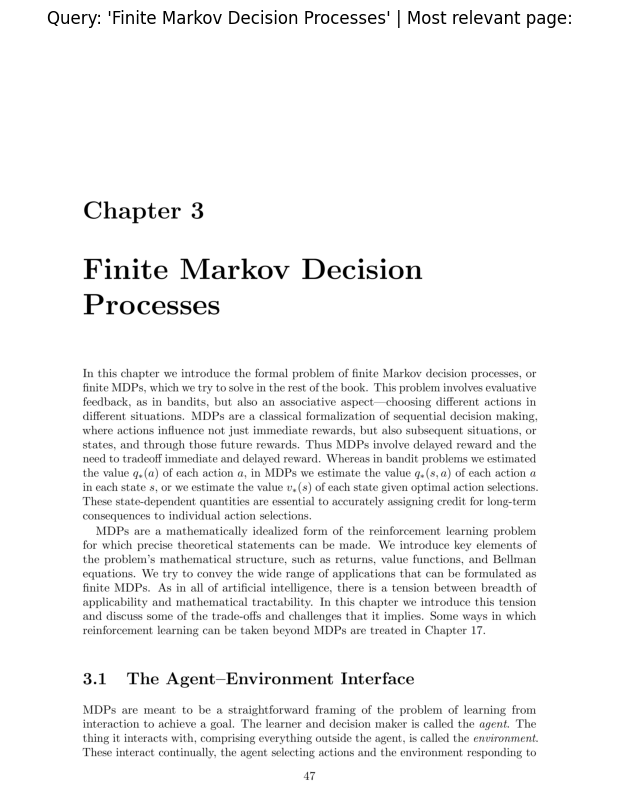

In [37]:
pdf = "book.pdf"

# Open PDF and load target page
doc = fitz.open(pdf)
page = doc.load_page(69-1) # number of page

# Get the image of the page
img = page.get_pixmap(dpi=300)

doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(
    img.samples_mv,
    dtype=np.uint8
).reshape((img.h, img.w, img.n))

plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()

### Similarity measures: dot product and cosine similarity

- **Cosine Similarity**: A metric used to measure how similar two vectors (i.e., embeddings) are. It ranges between -1 (completely dissimilar) to 1 (identical).
- **Top-k Retrieval**: We fetch the top-k most relevant sentences based on their similarity scores.


In [38]:
def dot_product(vec1, vec2):
    return torch.dot(vec1, vec2)

def cosine_similarity(vec1, vec2):
    dot_product = torch.dot(vec1, vec2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vec1 = torch.sqrt(torch.sum(vec1**2))
    norm_vec2 = torch.sqrt(torch.sum(vec2**2))

    return dot_product / (norm_vec1 * norm_vec2)

# Example tensors
vec1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vec2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vec3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vec4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vec1, vec2))
print("Dot product between vector1 and vector3:", dot_product(vec1, vec3))
print("Dot product between vector1 and vector4:", dot_product(vec1, vec4))

# Calculate cosine similarity
print("\nCosine similarity between vector1 and vector2:", cosine_similarity(vec1, vec2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vec1, vec3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vec1, vec4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)

Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Semantic Search Pipeline
### Building the Retrieval Function
We implement a function that retrieves relevant sentences based on a user query. The query is embedded using the same model, and then dot product similarity is calculated between the query embedding and the stored embeddings.

In [39]:
def retrieve_relevant_resources(
        query: str,
        embeddings: torch.tensor,
        model: SentenceTransformer=embedding_model,
        n_resources_to_return: int=5,
        print_time: bool=True
):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True).to(device)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices


def print_top_results_and_scores(
        query: str,
        embeddings: torch.tensor,
        pages_and_chunks: list[dict]=pages_and_chunks,
        n_resources_to_return: int=5
):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: '{query}'\n")
    print("Results:\n")

    # Loop through zipped together scores and indicies from torch.topk
    for score, idx in zip(top_result[0], top_result[1]):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print("\nText:")
        print_wrapped(pages_and_chunks[idx]["sen_chunk"])
        # Print the page number too so we can reference the textbook further (and check the results)
        print(f"Page number: {pages_and_chunks[idx]['page_no']}")
        print("\n")

In [40]:
print_top_results_and_scores(query="Monte Carlo", embeddings=embeddings)

[INFO] Time taken to get scores on 1528 embeddings: 0.00015 seconds.
Query: 'Monte Carlo'

Results:

Score: 0.7753

Text:
68 Chapter 3: Finite Markov Decision Processes 3.8 Summary Let us summarize the
elements of the reinforcement learning problem that we have presented in this
chapter. Reinforcement learning is about learning from interaction how to behave
in order to achieve a goal. The reinforcement learning agent and its environment
interact over a sequence of discrete time steps. The speciﬁcation of their
interface deﬁnes a particular task: the actions are the choices made by the
agent; the states are the basis for making the choices; and the rewards are the
basis for evaluating the choices. Everything inside the agent is completely
known and controllable by the agent; everything outside is incompletely
controllable but may or may not be completely known. A policy is a stochastic
rule by which the agent selects actions as a function of states. The agent’s
objective is to maximize

# Generation

In [41]:
gpu_memory = torch.cuda.get_device_properties(0).total_memory
gpu_memory = round(gpu_memory / (2**30))

print(f"GPU Memory: {gpu_memory} GB")

GPU Memory: 4 GB


### Model Selection: `google/gemma-2-2b-it`
Given the 4GB VRAM of the available GPU, the `google/gemma-2-2b-it` model has been chosen for this task. It offers a good balance between performance and memory requirements, making it suitable for resource-constrained environments.

- **Model Size**: 2 billion parameters, providing a powerful yet manageable model for tasks within the given VRAM constraints.

While there are larger models available that may offer more advanced capabilities, this model is optimal for current hardware. Other models can be explored for experimentation when higher resources are available.

In [85]:
model_id = "google/gemma-2-2b-it"
use_quantization_config = True

quantization_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_compute_dtype=torch.float16
)

if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

model_id = model_id
print(f"[INFO] Using model_id: {model_id}")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

llm_model = AutoModelForCausalLM.from_pretrained(
  pretrained_model_name_or_path=model_id,
  torch_dtype=torch.float16,
  quantization_config=quantization_config if use_quantization_config else None,
  low_cpu_mem_usage=True,
  attn_implementation=attn_implementation,
)

if not use_quantization_config:
  llm_model.to("cuda")

[INFO] Using attention implementation: flash_attention_2
[INFO] Using model_id: google/gemma-2-2b-it


Trying to resume download...
Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.61s/it]


In [86]:
llm_model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2FlashAttention2(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_laye

In [87]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1602203904

In [88]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2192283136, 'model_mem_mb': 2090.72, 'model_mem_gb': 2.04}

In [89]:
input_text = "What is reinforcement learning?"
print(f"Input text:\n{input_text}")

dialogue_template = [
    {"role": "user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(
    conversation=dialogue_template,
    tokenize=False,
    add_generation_prompt=True
)

print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is reinforcement learning?

Prompt (formatted):
<bos><start_of_turn>user
What is reinforcement learning?<end_of_turn>
<start_of_turn>model



In [90]:
input_text = "What is reinforcement learning in AI and ML?"
print(f"Input text:\n{input_text}")

# Manually formatting the dialogue template
dialogue_template = [
    {"role": "user", "content": input_text}
]

# Format the prompt manually
formatted_prompt = "User: " + dialogue_template[0]["content"]
print(f"Formatted Prompt:\n{formatted_prompt}")

# Tokenizing the prompt manually
prompt = tokenizer(formatted_prompt, return_tensors="pt").to("cuda")
print(f"\nTokenized Prompt:\n{prompt}\n")

Input text:
What is reinforcement learning in AI and ML?
Formatted Prompt:
User: What is reinforcement learning in AI and ML?

Tokenized Prompt:
{'input_ids': tensor([[     2,   2224, 235292,   2439,    603,  57890,   6044,    575,  16481,
            578,  29762, 235336]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}



In [91]:
%%time

# Generate outputs based on the tokenized input
# Use the generate function to create responses from the model
outputs = llm_model.generate(**prompt, max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")

# Decode the generated tokens back to text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated Text:\n{generated_text}")

The 'max_batch_size' argument of HybridCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Model output (tokens):
tensor([     2,   2224, 235292,   2439,    603,  57890,   6044,    575,  16481,
           578,  29762, 235336,    109,    688,  75111,  14707,  14715,    591,
          7585,  77056,    603,    476,   1916,    576,   6479,   6044,   1570,
           671,   5231,  16661,    688,  59938,    577,  44171,    575,    671,
          4473,    731,  57728,    675,    665,    578,  14051,   5231,  97143,
           688,    689,   5231,   2162, 167906,    688,    604,   1277,   8737,
        235265, 235248,    109,   4858, 235303, 235256,    476,  25497, 235292,
           109,    688,   2469,  38544,  66058,    109, 235287,   5231,  19979,
         66058,    714,  65736, 235269,    573,  12395,    674, 113211,    675,
           573,   4473, 235265,    108, 235287,   5231,  15569,  66058,    714,
          2134,    689,   1812,    573,  10588, 113211,    675, 235265,    108,
        235287,   5231,   2366,  66058,    714,   2474,   5841,    576,    573,
          4473, 2

In [97]:
# questions generated with GPT4

gpt4_questions = [
    "What are the key differences between reinforcement learning and supervised learning?",
    "Can you explain the concept of the exploration-exploitation trade-off in reinforcement learning?",
    "What are the main components of a reinforcement learning problem?",
    "How do value functions and policies differ in reinforcement learning?",
    "What are some common algorithms used in reinforcement learning, and how do they work?",
]

manual_questions = [
    "What is reinforcement learning?",
    "How does the exploration-exploitation trade-off work in reinforcement learning?",
    "What are the key differences between supervised and reinforcement learning?",
    "How can reinforcement learning be applied in game development?",
    "What role do rewards play in reinforcement learning?"   
]

query_list = gpt4_questions + manual_questions

In [98]:
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
scores, indices

Query: How can reinforcement learning be applied in game development?
[INFO] Time taken to get scores on 1528 embeddings: 0.00007 seconds.


(tensor([0.6205, 0.6124, 0.6032, 0.6025, 0.5986], device='cuda:0'),
 tensor([1042,   73, 1094,  504, 1200], device='cuda:0'))

# Augmentation

### Augmentation with Contextual Information

In this section, we focus on augmenting the input prompt for the language model with relevant context. By enhancing the base query with selected excerpts from the provided resources, we can significantly improve the quality of the generated responses.

**Objective**:  
To enhance the LLM's output by providing relevant context from the source materials (e.g., PDFs or other documents). This process is critical for a task like retrieval-augmented generation (RAG) where context-aware answers are necessary.

**Process Overview**:
1. **Context Retrieval**:  
   First, we retrieve relevant content based on the query by using embeddings to find the most suitable chunks of text.
   
2. **Prompt Formatting**:  
   Once the context is gathered, the next step is to format the query into a prompt that includes this context. The goal is to guide the LLM in generating more accurate and context-driven answers. 
   
3. **Examples in Prompting**:  
   To further refine the quality of answers, example queries and answers are embedded within the prompt. This helps the model understand the structure and depth of responses we expect.

**Why Augmenting Matters**:  
Simply asking the model a question without additional context can lead to generic or inaccurate answers. By feeding it with relevant sections from the documents, we direct its attention to the information needed to generate precise and detailed responses.

**Key Steps in Augmentation**:
- **Context Items**: Extracting relevant text chunks.
- **Prompt Construction**: Building a detailed prompt that combines the base query with the retrieved context.
- **Query Optimization**: Refining the query to ensure the language model generates insightful responses based on the provided context.

In the following cells, we implement these steps and leverage the language model's capabilities to create contextually rich answers to user queries.

In [113]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sen_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    base_prompt = """
        Based on the following context items from "Reinforcement Learning: An Introduction," please answer the user query in a comprehensive and informative manner.
        Ensure your response includes relevant details, examples, and analogies where applicable. 

        Instructions:
        - Extract relevant passages from the provided context before formulating your answer.
        - Focus on clarity and depth; aim for a thorough explanation rather than a brief response.
        - Do not include your reasoning process; only present the final answer.

        Use the following examples as references for the ideal answer style:
        \nExample 1:
        Query: What are the key components of reinforcement learning?
        Answer: The key components of reinforcement learning include the agent, environment, state, action, reward, and policy. The agent learns to maximize rewards through interactions with the environment, where actions are determined by the agent's policy based on the current state. Each component plays a crucial role in the learning process.

        \nExample 2:
        Query: What is the difference between exploration and exploitation?
        Answer: Exploration involves trying new actions to discover their effects, while exploitation leverages known actions that yield high rewards. Balancing exploration and exploitation is crucial; too much exploration can lead to missed opportunities, while excessive exploitation may prevent learning new and potentially better strategies.

        \nExample 3:
        Query: How do value functions and policies differ in reinforcement learning?
        Answer: Value functions estimate the expected return or future rewards of a certain state or action, providing a measure of the desirability of states, whereas policies define the strategy the agent follows to choose actions in various states. Effective learning relies on both concepts to guide the agent's behavior.

        \nNow use the following context items to answer the user query:
        {context}
        \nRelevant passages: <extract relevant passages from the context here>
        User query: {query}
        Answer:
        """ 

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(
        conversation=dialogue_template,
        tokenize=False,
        add_generation_prompt=True
    )

    return prompt

In [114]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query, context_items=context_items)
print(prompt)

Query: What are the main components of a reinforcement learning problem?
[INFO] Time taken to get scores on 1528 embeddings: 0.00012 seconds.
<bos><start_of_turn>user
Based on the following context items from "Reinforcement Learning: An Introduction," please answer the user query in a comprehensive and informative manner.
        Ensure your response includes relevant details, examples, and analogies where applicable. 

        Instructions:
        - Extract relevant passages from the provided context before formulating your answer.
        - Focus on clarity and depth; aim for a thorough explanation rather than a brief response.
        - Do not include your reasoning process; only present the final answer.

        Use the following examples as references for the ideal answer style:
        
Example 1:
        Query: What are the key components of reinforcement learning?
        Answer: The key components of reinforcement learning include the agent, environment, state, action, rewar

In [115]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(
    **input_ids,
    temperature=0.3, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
    do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
    max_new_tokens=256 # how many new tokens to generate from prompt 
) 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What are the main components of a reinforcement learning problem?
RAG answer:
<bos>A reinforcement learning problem comprises a learning agent, an environment, a policy, a reward signal, and a value function. The agent learns to maximize the total reward over the long run by interacting with the environment, taking actions based on its policy. The policy defines the agent's behavior in various states, while the reward signal defines the goal of the learning agent. The value function estimates the expected return or future rewards of a certain state or action, and it guides the agent's behavior. 
<end_of_turn>
CPU times: user 26.1 s, sys: 1.84 s, total: 28 s
Wall time: 28.8 s


In [119]:
def ask(
    query: str,
    temperature: float = 0.3,
    max_new_tokens: int = 256,
    format_ans_text: bool = True,
    return_ans_only: bool = True
):
    """
    Takes a query, finds relevant resources/context, and generates an answer
    based on the relevant resources.
    
    Args:
        query (str): The input question to be answered.
        temperature (float): Sampling temperature for generating responses.
        max_new_tokens (int): Maximum number of tokens to generate in the response.
        format_ans_text (bool): Whether to format the answer text.
        return_ans_only (bool): Whether to return only the answer text or also context items.

    Returns:
        str or tuple: The generated answer, and optionally the context items.
    """
    
    # Retrieve relevant resources based on the query
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
    context_items = [pages_and_chunks[i] for i in indices]

    # Attach scores to context items
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # Format the prompt for the language model
    prompt = prompt_formatter(query=query, context_items=context_items)

    # Tokenize the prompt and generate output from the model
    input_ids = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = llm_model.generate(
        **input_ids,
        temperature=temperature,
        max_new_tokens=max_new_tokens,
        do_sample=True
    )

    # Decode the generated tokens to text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer text if required
    if format_ans_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "").strip()

    # Return either the formatted answer or both the answer and context items
    return output_text if return_ans_only else (output_text, context_items)

In [120]:
query = random.choice(query_list)
print(f"Query: {query}")

answer, context_items = ask(
    query=query,
    temperature=0.5,
    max_new_tokens=512,
    return_ans_only=False
)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What are the key differences between supervised and reinforcement learning?
[INFO] Time taken to get scores on 1528 embeddings: 0.00008 seconds.
Answer:

Reinforcement learning differs from supervised learning, which relies on labeled
examples, and unsupervised learning, which involves discovering hidden
structures within unlabeled data.  It focuses on learning from interactions with
an environment, maximizing rewards through actions, and learning through trial-
and-error.  Reinforcement learning algorithms utilize a policy, a reward signal,
a value function, and optionally a model of the environment to guide their
behavior. Supervised learning relies on labeled examples, while unsupervised
learning focuses on discovering hidden patterns in unlabeled data. It's
important to note that the terms and phrases used in reinforcement learning are
often borrowed from animal learning theories, but the computational/engineering
meanings of these terms and phrases do not always coincide wi

[{'page_no': 24,
  'sen_chunk': 'Any method that is well suited to solving such problems we consider to be a reinforcement learning method. Reinforcement learning is di↵erent from supervised learning, the kind of learning studied in most current research in the ﬁeld of machine learning. Supervised learning is learning from a training set of labeled examples provided by a knowledgable external supervisor. Each example is a description of a situation together with a speciﬁcation—the label—of the correct action the system should take to that situation, which is often to identify a category to which the situation belongs. The object of this kind of learning is for the system to extrapolate, or generalize, its responses so that it acts correctly in situations not present in the training set. This is an important kind of learning, but alone it is not adequate for learning from interaction. In interactive problems it is often impractical to obtain examples of desired behavior that are both co

In [122]:
query = random.choice(query_list)
print(f"Query: {query}")

answer = ask(
    query=query,
    temperature=0.5,
    max_new_tokens=512,
    return_ans_only=True
)

print(f"Answer:\n")
print_wrapped(answer)

Query: How does the exploration-exploitation trade-off work in reinforcement learning?
[INFO] Time taken to get scores on 1528 embeddings: 0.00012 seconds.
Answer:

The exploration-exploitation trade-off is a fundamental challenge in
reinforcement learning, where an agent needs to balance its actions between
exploring new actions and exploiting known actions to maximize rewards. It's a
constant dilemma as the agent needs to find a balance between these two
conflicting tasks.   The exploration process involves trying out new actions to
discover their effects, potentially finding better, unknown actions.
Exploitation, on the other hand, focuses on utilizing the actions that have
already been proven effective to maximize rewards.  The agent needs to strike a
balance between these two approaches.  If it only exploits its known actions, it
might miss out on better actions that haven't been explored yet.    The optimal
strategy involves a combination of exploitation and exploration.  To illu

In [123]:
query = "What is Q-Learning Algorithm and what are its basics?"

answer = ask(
    query=query,
    temperature=0.5,
    max_new_tokens=512,
    return_ans_only=True
)

print(f"Answer:\n")
print_wrapped(answer)

[INFO] Time taken to get scores on 1528 embeddings: 0.00007 seconds.
Answer:

Q-learning is a method for learning optimal policies in sequential decision-
making problems. It operates on the principle of value-based learning. The
algorithm involves estimating the value of states and actions, aiming to find
the best action to take in each situation. It employs an update process that
refines the estimated values of states and actions based on the rewards received
from those states and actions.   The Q-learning algorithm utilizes a "Q-table"
which acts as a lookup table to store the estimated value of each state-action
pair.  The algorithm iteratively updates this table by comparing the actual
rewards received from taking an action in a given state, and then uses these
comparisons to update the values associated with each state-action pair.  The
process involves the following key steps:  1. **Initialization:** The algorithm
starts with an initial Q-table, which is filled with random value

### Conclusion: Building an End-to-End PDF Retrieval and QA System
In this notebook, we built a system that extracts information from a PDF, embeds sentences using a transformer model, retrieves relevant context for a query, and generates a well-formed answer using an LLM.

The key components of this pipeline include:
- Text extraction and tokenization.
- Embedding generation and retrieval using similarity search.
- Querying an LLM to produce high-quality answers.

This workflow is highly customizable and can be adapted for a variety of tasks, such as document summarization, question answering, and knowledge retrieval.